In [2]:
import geopy
from geopy.extra.rate_limiter import RateLimiter


import pandas as pd
import numpy as np
import geopandas as gpd

from matplotlib import pyplot as plt
import shapely

%matplotlib inline

import contextily as ctx
import requests
import plotly.express as px
from zipfile import ZipFile
import json
import random
import os, urllib
import seaborn  as sbn

#from tqdm.auto import tqdm, trange
from tqdm import tqdm, trange
tqdm.pandas()

from geopy_nominatim_wrapper import NominatimWrapper
from geopy_bestaddress import BestAddress
from geopy_pelias import Pelias
from geopy_bepelias import BePelias


from credentials import (here_api_key, 
                         bing_api_key, 
                         mapbox_api_key, 
                         tomtom_api_key, 
                         google_api_key, 
                         best_client_id, best_client_secret, best_hostname)



fig_path = "output/geocoding/figs"
data_dir = "data/geocoding"
output_dir="output/geocoding/"
# from fpdf import FPDF 

ImportError: DLL load failed while importing _imaging: The specified module could not be found.

In [117]:
# dataset = "rrn_1000"
# dataset = "kbo_1000"
# dataset = "best_1000"
# dataset = "best2_1000"
# dataset = "rep_1000"
# dataset = "resto_1000"

dataset = "kbo_10000"
# dataset = "rrn_10000"
# dataset = "rep_10000"
# dataset = "best_10000"

In [118]:
crs =     'epsg:3857'
osm_crs=  'epsg:4326'

In [119]:
def_figsize = (10,8)

In [120]:
os.makedirs(f"{output_dir}/geocoded_data/", exist_ok=True)
os.makedirs(f"{output_dir}/reports/", exist_ok=True)
os.makedirs(fig_path, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)


In [121]:
def add_basemap(ax, zoom='auto'):
    """
    Add a basemap on a plot. Tries first default (Stamen) basemap. If errors, tries OpenStreetMap.Mapnik
    
    Parameters
    ----------
    ax: matplotlib axes
    
    Returns
    -------
        None
    """

    try: 
#         ctx.add_basemap(ax, zoom=zoom)
#     except requests.HTTPError:
#         print("Default basemap doesn't work...")
        ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=zoom)
    except ValueError as e:
        print("Value error...")
        print(e)
    except NameError as e:
        print("contextily not installed")

In [122]:
def set_optimal_limits(ax, df):
    """
    Adapt xlim/ylim to a GeoDataFrame point plot to avoid plot to be too wide when 
    points are horizontally aligned, and to narrow when points are vertically aligned

    Usage : 
    
    ax = df.plot()
    set_optimal_limits(ax, df)
    
    Parameters
    ----------
    ax: AxesSubplot
       plot to resize
    df: GeoDataFrame
       data to be plotted

    Returns
    -------
        None
    """
    
    plot_ratio = 1.5 # optimal ratio between "one horizontal degree" and "one vertical degree". It depends of the CRS. 
                     # For "polar" CRS, it may also depend of the place on the globe

    minimal_width=200
   
    margins = 1.1 # Avoid having dots on edges of the plot
    

    # Compute dimension of the data
    xmin, ymin, xmax, ymax = df.total_bounds
    height = (ymax - ymin) 
    width = (xmax - xmin)
    
    opt_height = max(height, width / plot_ratio, minimal_width / plot_ratio)
    opt_width  = max(width , height*plot_ratio, minimal_width)
    
#     print(xmin, ymin, xmax, ymax)
#     print(width, height, opt_width, opt_height)
    # If plot is too narrow, increase xmin. If plot is too wide, increase ylim

    if opt_height > height :
        ymid = (ymax+ymin)/2
        mid_height = opt_height * margins / 2
        ax.set_ylim(ymid - mid_height, ymid + mid_height)
    if opt_width > width:
        xmid = (xmax+xmin)/2
        mid_width = opt_width* margins/2
        ax.set_xlim(xmid - mid_width, xmid + mid_width)

In [123]:
def pdf_savefig():
    try: 
        pdf.savefig(bbox_inches='tight')
    except AttributeError:
        print("PDF probably closed")

In [124]:
# plot_address(geocoded_data, geocoded_data.iloc[5].address)

# Prepare geocoders

In [125]:
def get_precision(record):
    
    precision_field= {
        "nominatim": "class",
        "nominatim_loc": "class",
        "nominatim_wrapper": ("metadata", "placeRank"),
#         "nominatim_wrapper2": "place_rank",
        "here": "MatchLevel",
        "photon": ("properties", "type"),
        "bing": "entityType",
        "mapbox": ("properties", "accuracy"),
        "tomtom": "type",
        "trillium": "match_level",
        "google":("geometry", "location_type"),
        "bestaddress": "precision",
        "lpost_bestaddress": "precision"
    }
    
    label_mapping = {
        "nominatim": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
                      
                      
        "nominatim_loc": {"building": "building",
                      "amenity":  "building",
                      "shop":     "building",
                      "place":    "building",
                      "highway":  "street"},
        
        "nominatim_wrapper": {"30": "building", 
                              "27": "street",
                              "26": "street",
                              "25": "city",
                              "22": "city",
                              "21": "city",
                              "20": "city",
                              "19": "city",
                              "18": "city",
                              "16": "city",
                              "14": "city"},

        "here": {"houseNumber": "building",
                "street": "street",
                "city": "city",
                "postalCode": "city"},
        "photon": {
            "house": "building",
            "locality": "city",
            "district": "city",
            "city": "city",
            "street": "street"},
        "bing": { "Address": "building",
                  "RoadBlock": "street",
                 "PopulatedPlace": "city",
                 "Postcode1": "city",
                 "CountryRegion": "country"
                },
        "mapbox": {"rooftop": "building",
                   "point": "building",
                   "interpolated": "building",
                  "street": "street"},
        
        "tomtom": {"Point Address": "building",
                  "Street": "street",
                  "Address Range": "street",
                  "Cross Street": "street",
                  "Geography": "city"},
        "trillium": {0:"building",
                      2: "city",
                      3: "street"},
        "google" : {
            "ROOFTOP": "building",
            "RANGE_INTERPOLATED": "building",
            "GEOMETRIC_CENTER": "street",
            "APPROXIMATE": "city"
        },
        "bestaddress":{
            "building": "building",
            "street":"street",
            "country": "country",
            "city":"city"
        },
        "lpost_bestaddress":{
        "building": "building",
        "street":"street",
        "country": "country"
        }
    }
    
    if "pelias" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        
        raw_label = record.location.raw["properties"]
        
        if (raw_label["match_type"] in ["exact", "interpolated"] or raw_label["accuracy"]=="point") and 'housenumber' in raw_label:
            return "building"
        if "street" in raw_label:
            return "street"
        if "region" in raw_label:
            return "city"
        return "country"
    
    if "jcd" in record.geocoder:
        
        if record.location.point == geopy.Point(0,0):
            return "country"
        return "building"
        
    
    try: 
        f = precision_field[record.geocoder]
        mapper = label_mapping[record.geocoder]
        if isinstance(f, str):
            raw_label = record.location.raw[f]
        else: 
            raw_label =  record.location.raw[f[0]][f[1]]
        return mapper[raw_label] if raw_label in mapper else f"[UNKNOWN - {raw_label}]"
    except KeyError: 
        if record.geocoder == "mapbox":
            return "city"
        return "[UNKNOWN]"
    
    

In [126]:
geocoders = {}

In [127]:
from geopy.geocoders import Nominatim
geocoders['nominatim'] = Nominatim(user_agent="smalsresearch", domain="172.27.0.64:8080", scheme="http", timeout=1000)
# geocoders['nominatim'] = Nominatim(user_agent="smalsresearch")


In [128]:
geocoders['nominatim_wrapper'] = NominatimWrapper(user_agent="smalsresearch", scheme="http", timeout=1000, domain="172.27.0.64:5000")

In [129]:
geocoders['bestaddress'] = BestAddress(user_agent="smalsresearch", scheme="https", timeout=1000, 
                                       client_id=best_client_id, client_secret=best_client_secret,
                                       domain=best_hostname,
                                       verbose=False
                                      )

In [130]:
# from geopy.geocoders import Pelias
geocoders['pelias']        = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4005", scheme="http", timeout=1000)
geocoders['pelias_struct'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4005", scheme="http", timeout=1000)
geocoders['pelias_struct_noloc'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4005", scheme="http", timeout=1000, with_localities=False)


In [131]:
# geocoders['pelias'].geocode("Rue de Namur 23, 5190 Spy")

In [132]:
# geocoders['pelias_struct'].verbose=True
# geocoders['pelias_struct'].geocode({"street": "Avenue Fonsny", "housenumber": "20", "postcode": "1060", "city": "Saint-Gilles"})
# geocoders['pelias_struct'].geocode({"street": "Rue des Vierges", "housenumber": "25", "postcode": "9600", "city": "Renaix"})

# geocoders['pelias_struct'].geocode({""		Renaix


In [133]:
# geocoders['pelias_struct'].with_localities

In [134]:
# from geopy.geocoders import Pelias
# For peliase installed through bePelias procedure
geocoders['be_pelias_basic_unstruct']        = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['be_pelias_basic_struct'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000)
geocoders['be_pelias_basic_struct_noloc'] = Pelias(user_agent="smalsresearch", domain="172.27.0.64:4000", scheme="http", timeout=1000, with_localities=False)


In [135]:
# geocoders['be_pelias'].geocode({"street": "Rue des Vierges", "housenumber": "25", "postcode": "9600", "city": "renaix"}).raw

In [136]:
geocoders['be_pelias_basic'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="basic")


In [137]:
geocoders['be_pelias_simple'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
                                    mode="simple")


In [138]:
geocoders['be_pelias'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
#                                     mode="simple")
                                    mode="advanced")


In [139]:
# geocoders['be_pelias_basic_struct'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
# #                                     mode="simple")
#                                     mode="struct")

# geocoders['be_pelias_basic_struct_noloc'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
# #                                     mode="simple")
#                                     mode="struct_noloc")

# geocoders['be_pelias_basic_unstruct'] = BePelias(user_agent="smalsresearch", domain="172.27.0.64:4001", scheme="http", timeout=1000,
# #                                     mode="simple")
#                                     mode="unstruct")


In [140]:
from geopy.geocoders import Here
geocoders['here'] = Here(apikey=here_api_key)

In [141]:
from geopy.geocoders import Bing
geocoders['bing'] = Bing(api_key=bing_api_key)

In [142]:
from geopy.geocoders import Photon
# geocoders['photon'] = Photon(domain="photon.komoot.io")

geocoders['photon'] = Photon(domain="127.0.0.1:2322", scheme="http")

# geocoders['photon'].geocode("Avenue Fonsny 20, 1060 Bruxelles").raw

In [143]:
from geopy.geocoders import MapBox
geocoders['mapbox'] = MapBox(api_key=mapbox_api_key)

In [144]:
from geopy.geocoders import TomTom
geocoders['tomtom'] =TomTom(api_key=tomtom_api_key)

In [145]:
from geopy.geocoders import GoogleV3
geocoders["google"] = GoogleV3(api_key=google_api_key)

In [146]:
from matplotlib.backends.backend_pdf import PdfPages


In [147]:
# geocoders['be_pelias'].geocode({"street": "Avenue Sobieski", 
#                                 "housenumber": 5,
#                                 "postcode": 1020,
#                                 "city": "Laeken"}).raw

In [148]:
# geocoders['be_pelias_basic_unstruct'].geocode("Rue de Namur, 5190 Spy").raw

In [149]:
# geocoders['google'].geocode("Dorpstraat, Geldrode").raw

# Load data


In [150]:
data = pd.read_csv(f"{data_dir}/{dataset}.csv.gz", dtype=str)

mandatory_columns = ["street", "housenumber", "postcode", "city"]
for f in mandatory_columns:
    assert f in data, f"Field {f} is mandatory !!"


In [151]:
data["address"] = data.street.fillna("")+", "+data.housenumber.fillna("")+", "+data.postcode+" "+data.city+", Belgique"
data

,street,housenumber,postcode,city,address
0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be..."
1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles, Belgique"
2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde, Belgique"
3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt, Belgique"
4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle, Belgique"
...,...,...,...,...,...
9995,Willy Staeslei,51,2180,Antwerpen,"Willy Staeslei, 51, 2180 Antwerpen, Belgique"
9996,Oesterbankstraat,15,8400,Oostende,"Oesterbankstraat, 15, 8400 Oostende, Belgique"
9997,Peene,10,9185,Wachtebeke,"Peene, 10, 9185 Wachtebeke, Belgique"
9998,Breekpot(Onk),28,9500,Geraardsbergen,"Breekpot(Onk), 28, 9500 Geraardsbergen, Belgique"


In [152]:
data = data.reset_index().rename(columns={"index": "reference_key"})

In [153]:
# data

In [154]:
pdf = PdfPages(f"output/geocoding/reports/report_{dataset}.pdf")

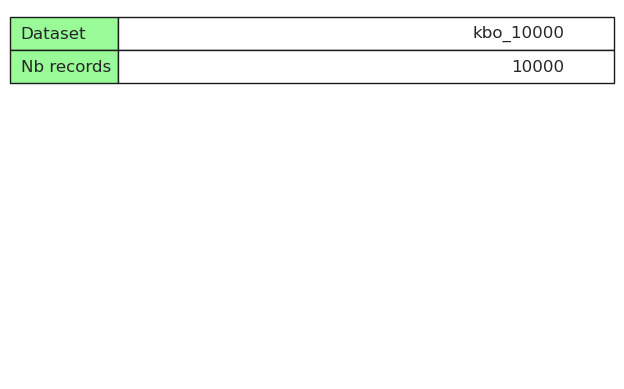

In [155]:
metadata= [["Dataset", dataset],
          ["Nb records", data.shape[0]]]


fig, ax =plt.subplots()
ax.set_axis_off() 
tbl = ax.table(cellText = [ r[1:] for r in metadata],
         rowLabels = [r[0] for r in metadata],
         rowColours = ["palegreen"] * len(metadata),
        loc="upper left")
tbl.scale(1,2)
pdf_savefig()

# Geocode

In [156]:
try: 
    no_res_timing = pd.read_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")
except FileNotFoundError: 
    no_res_timing = pd.DataFrame(columns =["address", "geocoder", "duration"] )

In [157]:
import datetime
#no_res_timing ={}
def geocode_and_timeit(geocoder, addr):
    global no_res_timing
    start = datetime.datetime.now()
    res = geocoder(addr)
    if res:
        res.raw.update({"duration": datetime.datetime.now()-start})
    else: 
        geocoder_name = list(filter(lambda y: y[1] == geocoder.__self__ , [(x, geocoders[x]) for x in geocoders]))[0][0]
        
        no_res_timing = pd.concat([no_res_timing, pd.DataFrame([{"address":  addr,
                                              "duration": (datetime.datetime.now()-start).total_seconds(), 
                                              "geocoder": geocoder_name}])])
    return res

In [164]:
geocoded_data_r = [] #gpd.GeoDataFrame()
coders=["nominatim_wrapper", "nominatim", "here", "bing", "mapbox", "tomtom", "google", "bestaddress", 
        "ngi_pelias"]
coders=["nominatim_wrapper", "nominatim", "here", "bing", "google", "tomtom", "ngi_pelias"]

coders=["nominatim", "be_pelias", "here", "bing", "google", "tomtom"]

coders=["here", "bing", "google", "nominatim", "nominatim_wrapper", "be_pelias"]

# coders=["pelias_struct_noloc", "pelias_struct", "pelias"]

# coders=["be_pelias_basic_struct_noloc", "be_pelias_basic_struct", "be_pelias_basic_unstruct"]

# coders=["be_pelias"]

# coders=["be_pelias", "pelias_struct_noloc", "pelias_struct", "pelias"]

#coders=["be_pelias_basic_struct_noloc", "be_pelias_basic_struct", "be_pelias_basic_unstruct", "pelias_struct_noloc", "pelias_struct", "pelias"]

# coders=[ "bing", "google", "here", "tomtom", "nominatim", "nominatim_wrapper", "pelias", "ngi_pelias", "jcd"]
# coders=[ "bing", "google", "here", "tomtom", "nominatim", "pelias", "photon"]

# coders = ["here", "bing", "tomtom", "google", "nominatim_wrapper", "nominatim"]
# coders = ["here", "bing", "tomtom", "google", "nominatim_loc"]

# coders = ["nominatim"]
# from_file = coders
# from_file = [] 

# coders =["pelias", "pelias_struct", "ngi_pelias_basic", "ngi_pelias_simple", "ngi_pelias"]
# from_file=["pelias", "pelias_struct", ] 
# from_file = coders

coders = ["be_pelias"]
from_file=[] 
# from_file = coders


delay={"mapbox":0.5, "nominatim_wrapper":0.01,  "nominatim":0.01, "lpost_bestaddress": 0.01, "google":0.05, "tomtom": 0.4, 
       "bing": 0.05}
for c in coders:
    if "pelias" in c:
        delay[c] = 0.02


for coder in coders: #geocoders:
    print(coder)
    
    if coder in from_file:
        print("Load from local file...")
        g_data = pd.read_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    else: 
        
        # Erase no-res timing for this coder for any previous run
        no_res_timing = no_res_timing[no_res_timing.geocoder != coder]
        
        g = geocoders[coder]
        g.geocode_timeit = lambda x: geocode_and_timeit(g.geocode, x)
        geocode = RateLimiter(g.geocode_timeit, min_delay_seconds=delay[coder] if coder in delay else 0.2)

        if coder in ["bestaddress", "be_pelias", 'be_pelias_basic', 'be_pelias_simple', "pelias_struct", "pelias_struct_noloc",
                    "be_pelias_basic_struct", "be_pelias_basic_struct_noloc"]: # structured addresses
            g_data = data.assign(location=data[["street", "housenumber", "postcode", "city"]].apply(dict, axis=1).progress_apply(geocode)).assign(geocoder=coder)

        else: 
            g_data = data.assign(location=(data['address'].str.replace("/", "%2F") if coder=="tomtom" else data['address']).progress_apply(geocode)).assign(geocoder=coder)
#             g_data = data.assign(location=data['address'].progress_apply(geocode)).assign(geocoder=coder)
        g_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{coder}.pkl")
    
    geocoded_data_r.append(g_data)
    display(g_data)

be_pelias


100%|██████████| 10000/10000 [09:11<00:00, 18.12it/s]


,reference_key,street,housenumber,postcode,city,address,location,geocoder
0,0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be...","(200, Dendermondsesteenweg, 2830 Willebroek, (...",be_pelias
1,1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles, Belgique","(47, Boulevard du Régent, 1000 Bruxelles, (50....",be_pelias
2,2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde, Belgique","(44, Hauwaart, 9700 Oudenaarde, (50.83173, 3.6...",be_pelias
3,3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt, Belgique","(40, Bruynebosstraat, 3511 Hasselt, (50.97784,...",be_pelias
4,4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle, Belgique","(583, Steenwinkelstraat, 2627 Schelle, (51.122...",be_pelias
...,...,...,...,...,...,...,...,...
9995,9995,Willy Staeslei,51,2180,Antwerpen,"Willy Staeslei, 51, 2180 Antwerpen, Belgique","(51, Willy Staeslei, 2180 Antwerpen, (51.28986...",be_pelias
9996,9996,Oesterbankstraat,15,8400,Oostende,"Oesterbankstraat, 15, 8400 Oostende, Belgique","(15, Oesterbankstraat, 8400 Oostende, (51.2263...",be_pelias
9997,9997,Peene,10,9185,Wachtebeke,"Peene, 10, 9185 Wachtebeke, Belgique","(10A, Peene, 9185 Wachtebeke, (51.17131, 3.886...",be_pelias
9998,9998,Breekpot(Onk),28,9500,Geraardsbergen,"Breekpot(Onk), 28, 9500 Geraardsbergen, Belgique","(28, Breekpot, 9500 Geraardsbergen, (50.78497,...",be_pelias


In [45]:
# with_ref = geocoded_data_r[4]
# x = geocoded_data_r[9].merge(with_ref[["address", "reference_key"]])#

# x
# data[data.street.fillna("").str.contains("Rue du Hollu(RVX)", regex=False)]

In [46]:
# x.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_{x.geocoder.unique()[0]}.pkl")

## Gather results

In [165]:
geocoded_data = pd.concat(geocoded_data_r).reset_index(drop=True)
geocoded_data = geocoded_data[geocoded_data.location.notnull()]
geocoded_data

,reference_key,street,housenumber,postcode,city,address,location,geocoder
0,0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be...","(200, Dendermondsesteenweg, 2830 Willebroek, (...",be_pelias
1,1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles, Belgique","(47, Boulevard du Régent, 1000 Bruxelles, (50....",be_pelias
2,2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde, Belgique","(44, Hauwaart, 9700 Oudenaarde, (50.83173, 3.6...",be_pelias
3,3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt, Belgique","(40, Bruynebosstraat, 3511 Hasselt, (50.97784,...",be_pelias
4,4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle, Belgique","(583, Steenwinkelstraat, 2627 Schelle, (51.122...",be_pelias
...,...,...,...,...,...,...,...,...
9995,9995,Willy Staeslei,51,2180,Antwerpen,"Willy Staeslei, 51, 2180 Antwerpen, Belgique","(51, Willy Staeslei, 2180 Antwerpen, (51.28986...",be_pelias
9996,9996,Oesterbankstraat,15,8400,Oostende,"Oesterbankstraat, 15, 8400 Oostende, Belgique","(15, Oesterbankstraat, 8400 Oostende, (51.2263...",be_pelias
9997,9997,Peene,10,9185,Wachtebeke,"Peene, 10, 9185 Wachtebeke, Belgique","(10A, Peene, 9185 Wachtebeke, (51.17131, 3.886...",be_pelias
9998,9998,Breekpot(Onk),28,9500,Geraardsbergen,"Breekpot(Onk), 28, 9500 Geraardsbergen, Belgique","(28, Breekpot, 9500 Geraardsbergen, (50.78497,...",be_pelias


In [166]:
# geocoded_data["geocoder"]=geocoded_data["geocoder"].replace("ngi_pelias", "pelias_plus")
# coders.append("pelias_plus")
# coders.remove("ngi_pelias")
# x = data.merge(geocoded_data[geocoded_data.geocoder=="ngi_pelias"].drop("address", axis=1)[["reference_key", "street", "housenumber", "postcode", "city"]].rename(columns={"street" : "pelias_street", 
#                                                                        "housenumber": "pelias_housenumber" ,
#                                                                        "postcode": "pelias_postcodee",
#                                                                        "city": "pelias_city"}), how="left")
# x

In [167]:
# geocoded_data

In [168]:
geocoded_data.geocoder.value_counts()

geocoder
be_pelias    9999
Name: count, dtype: int64

# Duration

In [169]:
geocoded_data["duration"] = geocoded_data["location"].apply(lambda loc: loc.raw["duration"] if loc and "duration" in loc.raw else None).dt.total_seconds()

In [170]:
geocoded_data.groupby("geocoder").address.count().sum()#["duration"]


9999

In [171]:
no_res_timing.to_pickle(f"output/geocoding/no_res_timing_{dataset}.pkl")

In [172]:
geocoded_data_duration = pd.concat([geocoded_data.assign(with_result=True), 
                                    no_res_timing[no_res_timing.geocoder.isin(coders)].assign(with_result=False)])
geocoded_data_duration = geocoded_data_duration.reset_index()[["address", "geocoder", "duration", "with_result"]]
geocoded_data_duration["address"] = geocoded_data_duration["address"].astype(str)

In [173]:
geocoded_data_duration.sort_values("duration")

,address,geocoder,duration,with_result
7932,"Holven, 13, 2490 Balen, Belgique",be_pelias,0.012879,True
6789,"Muiterij, 13, 9660 Brakel, Belgique",be_pelias,0.012907,True
6970,"Berg, 74, 2490 Balen, Belgique",be_pelias,0.013159,True
6940,"Beekvelden, 86, 2840 Rumst, Belgique",be_pelias,0.013245,True
9803,"Grand'Rue, 24, 7950 Chièvres, Belgique",be_pelias,0.013250,True
...,...,...,...,...
6152,"Rue Dourlet, SN, 6000 Charleroi, Belgique",be_pelias,1.587735,True
4264,"Grand-Rue, Châtillon, 110, 6747 Saint-Léger (L...",be_pelias,1.603222,True
6409,"Rue de Trehet, V.-lez-Heest, 4, 5080 La Bruyèr...",be_pelias,1.898872,True
8064,"Rue du Roy,Limerlé, 56, 6670 Gouvy, Belgique",be_pelias,2.273713,True


In [174]:
geocoded_data_duration.duration.quantile(0.99)

0.4398316300000005

/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/vb/anaconda3/envs/gis2/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


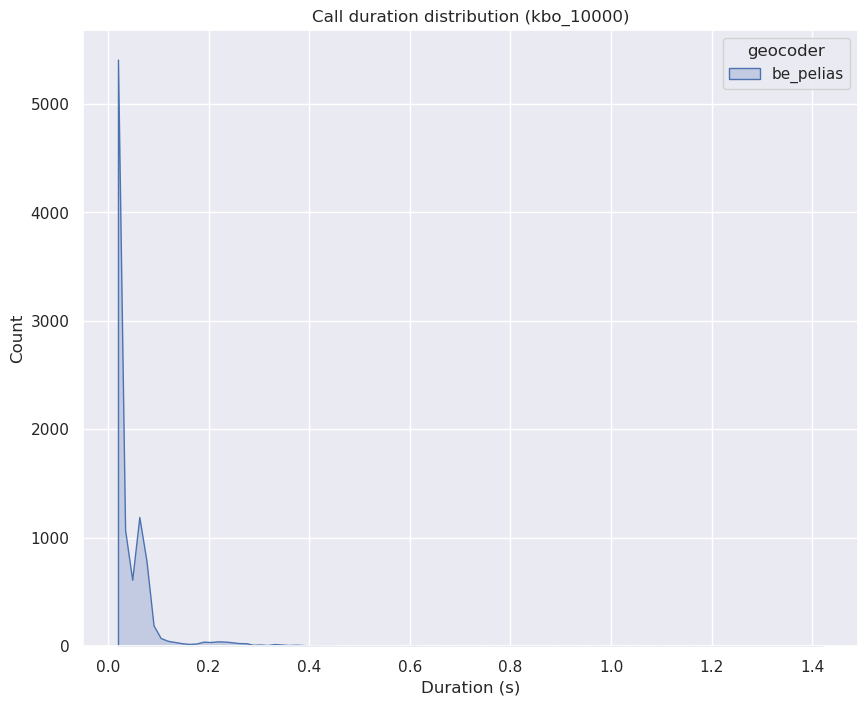

In [175]:
plt.figure(figsize=def_figsize)
sbn.histplot(geocoded_data_duration[geocoded_data_duration.duration<geocoded_data_duration.duration.quantile(0.999)].sort_values("geocoder"), 
             x="duration", hue="geocoder", element="poly",
            bins=100).set(title=f'Call duration distribution ({dataset})', xlabel="Duration (s)")

pdf_savefig()
    

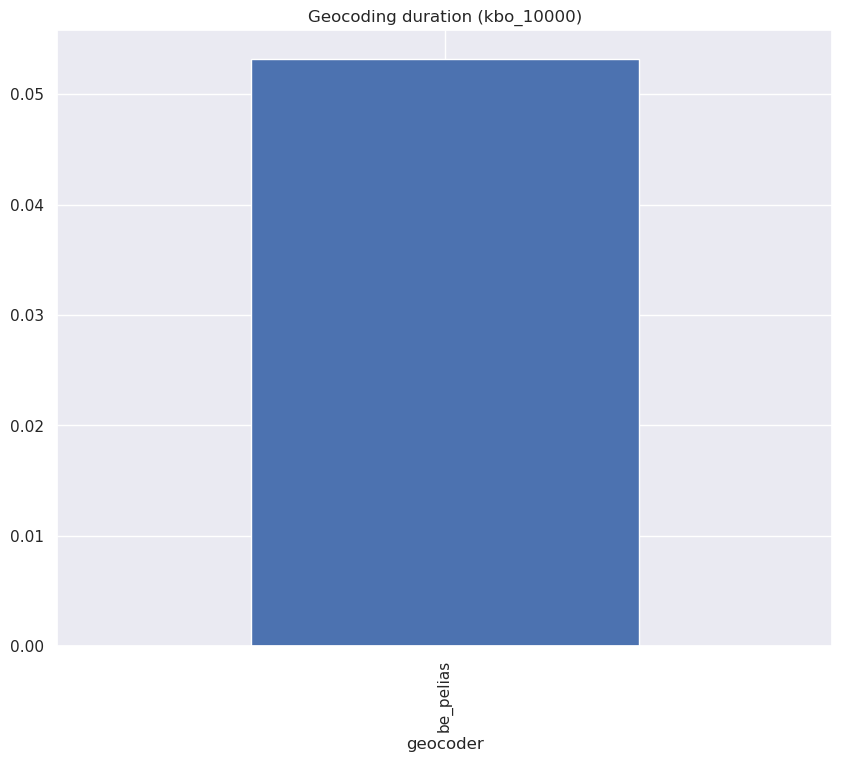

In [176]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

geocoded_data_duration.groupby("geocoder").duration.mean().plot.bar(color=colors, 
                                                                    title=f"Geocoding duration ({dataset})",
                                                                   figsize=def_figsize)
plt.savefig(f'{fig_path}/geocoding_speed.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

<Axes: title={'center': 'Geocoding duration (kbo_10000)'}, xlabel='geocoder'>

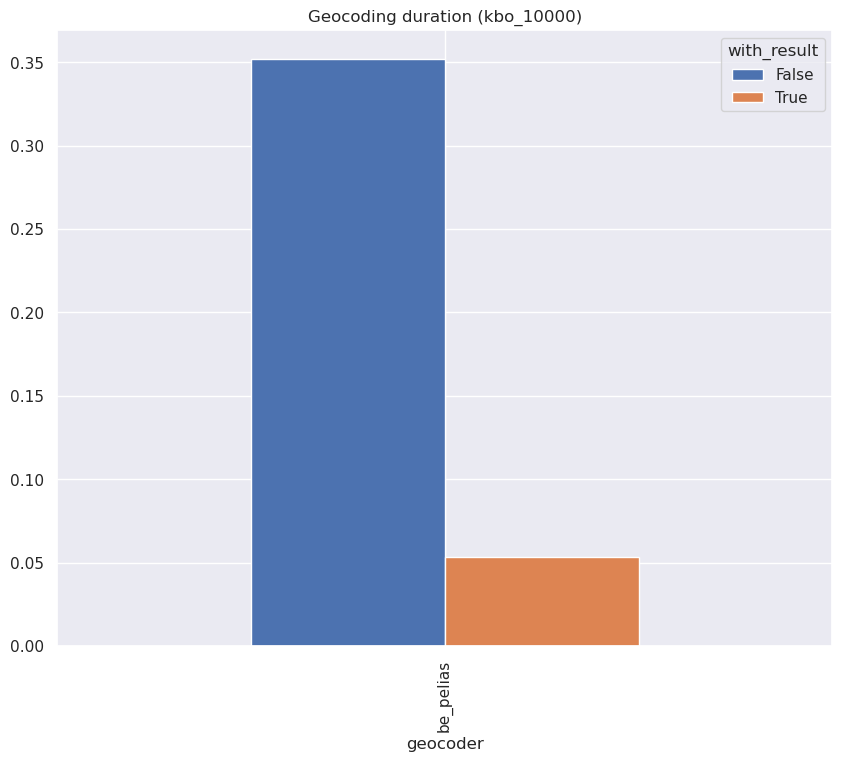

In [177]:
geocoded_data_duration.groupby(["geocoder", "with_result"]).duration.mean().unstack().plot.bar(title=f"Geocoding duration ({dataset})",
                                                                                              figsize=def_figsize)

In [178]:
# geocoded_data_duration[geocoded_data_duration.geocoder=="tomtom"]

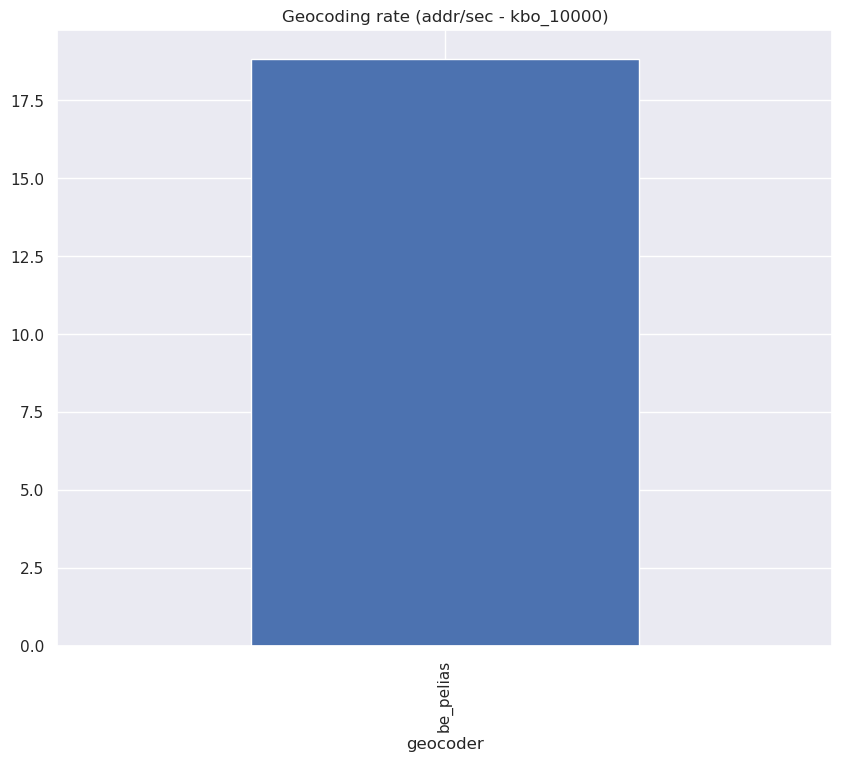

In [179]:
colors = [f"C{i}" for i in range(geocoded_data.geocoder.nunique())]

(1/geocoded_data_duration.groupby("geocoder").duration.mean()).plot.bar(color=colors, 
                                                                        title=f"Geocoding rate (addr/sec - {dataset})",
                                                                        figsize=def_figsize)
# plt.savefig(f'{fig_path}/geocoding_speed_rate.png', dpi=150,  bbox_inches='tight')

pdf_savefig()

# Matching rate

## Matching rate

In [180]:
# geocoded_data[geocoded_data.geocoder=="jcd"].reference_key.isnull().value_counts()

In [181]:
data

,reference_key,street,housenumber,postcode,city,address
0,0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be..."
1,1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles, Belgique"
2,2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde, Belgique"
3,3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt, Belgique"
4,4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle, Belgique"
...,...,...,...,...,...,...
9995,9995,Willy Staeslei,51,2180,Antwerpen,"Willy Staeslei, 51, 2180 Antwerpen, Belgique"
9996,9996,Oesterbankstraat,15,8400,Oostende,"Oesterbankstraat, 15, 8400 Oostende, Belgique"
9997,9997,Peene,10,9185,Wachtebeke,"Peene, 10, 9185 Wachtebeke, Belgique"
9998,9998,Breekpot(Onk),28,9500,Geraardsbergen,"Breekpot(Onk), 28, 9500 Geraardsbergen, Belgique"


In [182]:
mr = (geocoded_data.groupby("geocoder").address.count()/ data.shape[0])

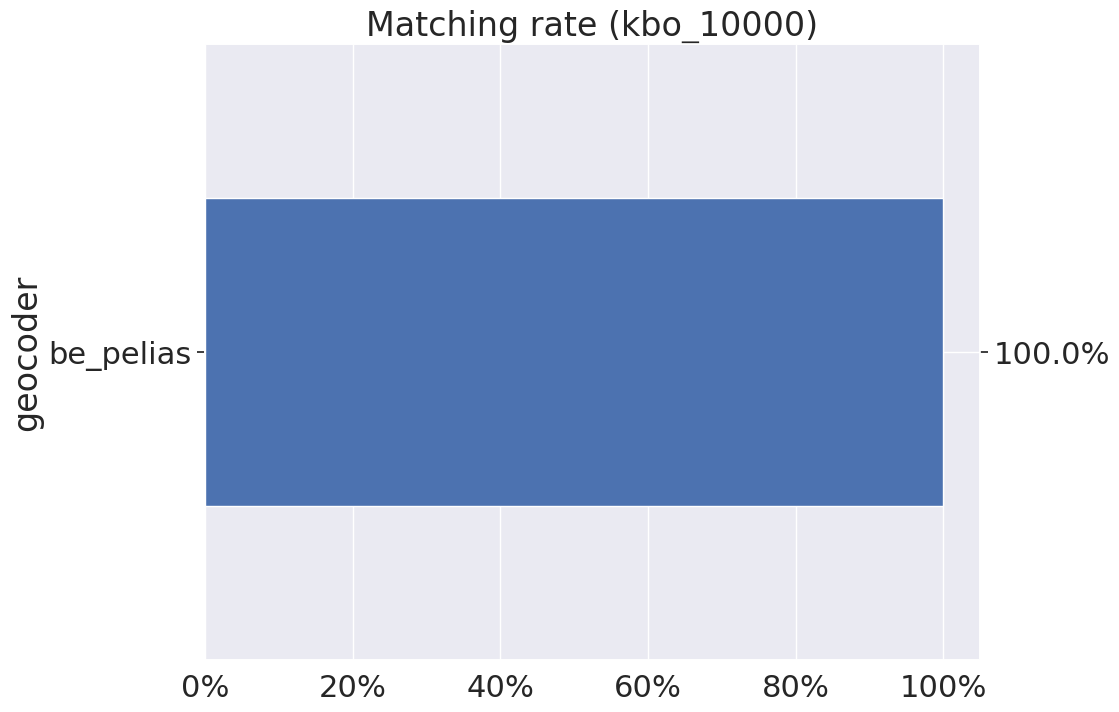

In [183]:
def show_values_on_hbars(ax, values):
    
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(ax.get_yticks())
    ax2.set_yticklabels(values.apply("{:.1%}".format))#mr_prec_plot.get_yticklabels())
    # ax2.xaxis.set_major_formatter('')
    ax2.grid(axis='y')   
    
    


plt.figure(figsize=def_figsize)
sbn.set(font_scale=2)

mr_plot=mr.rename("matching rate").plot.barh(title=f"Matching rate ({dataset})")

show_values_on_hbars(mr_plot, mr)


mr_plot.xaxis.set_major_formatter('{x:.0%}')


pdf_savefig()

sbn.set(font_scale=1)



In [184]:
# geocoded_data.groupby("address").geocoder.count().value_counts().sort_index(ascending=False).plot.bar(title="Number of success per address")

## Extract precision

In [185]:
geocoded_data["precision"] = geocoded_data.apply(get_precision, axis=1)

In [186]:
geocoded_data[geocoded_data.precision.str.contains("UNK")][["geocoder" , "precision"]].value_counts()#drop_duplicates()

Series([], Name: count, dtype: int64)

In [187]:
geocoded_data[geocoded_data.precision.str.contains("UNK")]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision


In [188]:
geocoded_data["precision"] = geocoded_data.precision.replace("^\[UNKNOWN.*\]", "[UNKNOWN]", regex=True)

## Precision

In [189]:
mr

geocoder
be_pelias    0.9999
Name: address, dtype: float64

In [190]:
def plot_matching_rate(geocoded_data, title=f"Matching rate - Precision ({dataset})"):
    sbn.set(font_scale=2)
    mr_prec = geocoded_data.groupby(["geocoder", "precision"]).address.count().unstack()
    mr_prec = mr_prec/data.shape[0]
    mr_prec = mr_prec.reindex(["building", "street", "city", "country"], axis=1).reindex(coders, axis=0) # , "[UNKNOWN]"

    mr_prec_plot= mr_prec.plot.barh(stacked=True, 
                                    figsize=def_figsize, 
                                    title=title, 
                                    color=["tab:green", "tab:orange", "tab:red", "darkred" , "tab:grey"])
    mr_prec_plot.xaxis.set_major_formatter('{x:.0%}')

    mr_prec_plot.set_ylabel(None)

    plt.legend(loc='lower left')

    show_values_on_hbars(mr_prec_plot, mr.reindex(coders))

    for bars in mr_prec_plot.containers:
        mr_prec_plot.bar_label(bars, label_type="center", fmt=lambda x: "{0:.0%}".format(x) if x >0.005 else "", fontproperties={"size":"x-small"})


    plt.savefig(f'{fig_path}/matching_rate_{dataset}.png', dpi=150,  bbox_inches='tight')

    sbn.set(font_scale=1)
    
    return mr_prec


In [191]:
import matplotlib
matplotlib.__version__


'3.8.0'

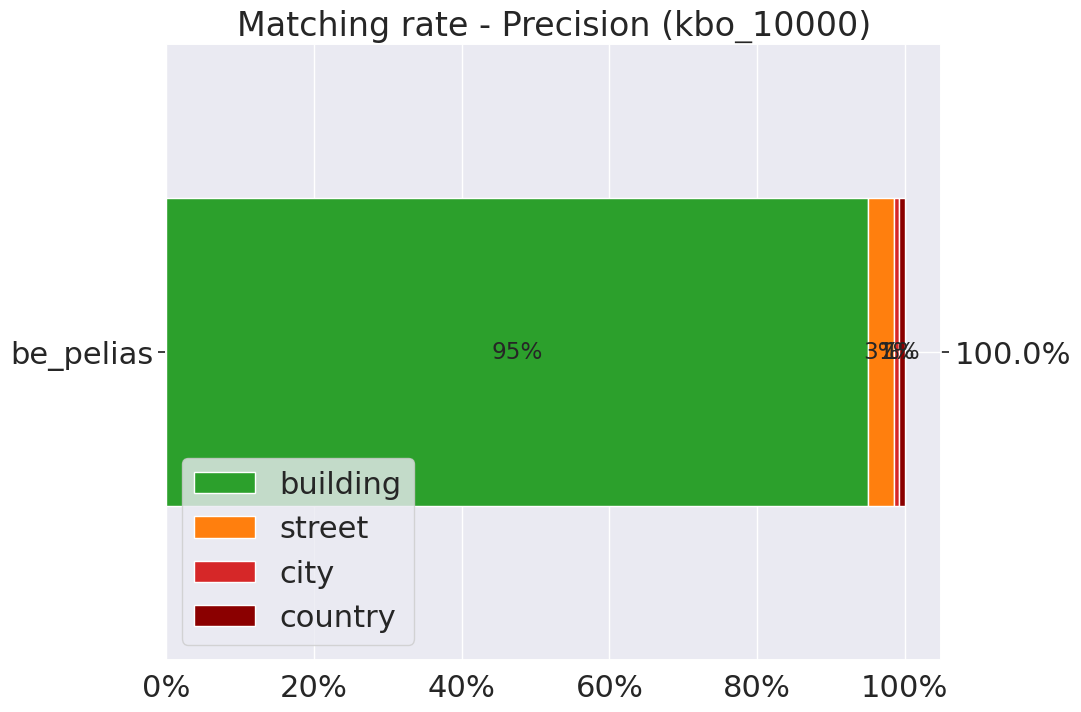

In [192]:
mr_prec = plot_matching_rate(geocoded_data)
pdf_savefig()

In [193]:
# no builing MR (for Nominatim):
# best : 31.6+0.4 = 32 %
# kbo : 24+1 = 25 %
# resto : 13.1 + 4.5 = 17.5 
with pd.option_context('display.float_format', '{:0.1%}'.format):
    display(mr_prec.fillna(""))


precision,building,street,city,country
geocoder,,,,
be_pelias,95.1%,3.5%,0.7%,0.8%


In [194]:
# kbo: ngi_pelias	93.4%	5.6%	0.9%	0.1%
#                   94.6%	4.5%	0.8%	0.1%
# rep: 94.4%	5.1%	0.4%	0.1%
#      95.8%	3.1%	0.4%	0.7%

# rrn: 97.3%	1.3%	0.3%	1.1%

geocoded_data[(geocoded_data.geocoder=="be_pelias_simple") & (geocoded_data.precision=="street")]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision


In [195]:
geocoded_data.loc[67].location.raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [3.74268, 51.04639]},
 'properties': {'id': 'bevlg_nl_1065515',
  'gid': 'be-vlg:address:bevlg_nl_1065515',
  'layer': 'address',
  'source': 'be-vlg',
  'source_id': 'bevlg_nl_1065515',
  'country_code': 'BE',
  'name': '8, Tinkstraat, 9000 Gent',
  'housenumber': '8',
  'street': 'Tinkstraat',
  'postalcode': '9000',
  'confidence': 1,
  'match_type': 'exact',
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Flemish Region',
  'macroregion_gid': 'whosonfirst:macroregion:404227357',
  'region': 'Oost-Vlaanderen',
  'region_gid': 'whosonfirst:region:85681733',
  'region_a': 'OV',
  'county': 'Ghent',
  'county_gid': 'whosonfirst:county:102049989',
  'county_a': 'GT',
  'localadmin': 'Gent',
  'localadmin_gid': 'whosonfirst:localadmin:1108830083',
  'locality': 'Ghent',
  'locality_gid': 'whosonfirst:locality:101748093',
  'label': '8, 

In [196]:
geocoded_data[geocoded_data.geocoder=="be_pelias_simple"].location.apply(lambda rec: rec.raw["bepelias"]["call_type"]).value_counts()

Series([], Name: count, dtype: int64)

In [197]:
pd.crosstab(geocoded_data[geocoded_data.geocoder=="be_pelias_simple"].location.apply(lambda rec: "openaddress" in rec.raw["properties"]["gid"]),
            geocoded_data[geocoded_data.geocoder=="be_pelias_simple"].precision)

precision
location


In [198]:
# geocoded_data[~geocoded_data.location.apply(lambda rec: "openaddress" in rec.raw["properties"]["gid"]) & (geocoded_data.precision=="building")]

In [199]:
geocoded_data.loc[0].location.raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [4.34673, 51.05949]},
 'properties': {'id': 'bevlg_nl_391785',
  'gid': 'be-vlg:address:bevlg_nl_391785',
  'layer': 'address',
  'source': 'be-vlg',
  'source_id': 'bevlg_nl_391785',
  'country_code': 'BE',
  'name': '200, Dendermondsesteenweg, 2830 Willebroek',
  'housenumber': '200',
  'street': 'Dendermondsesteenweg',
  'postalcode': '2830',
  'confidence': 1,
  'match_type': 'exact',
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Flemish Region',
  'macroregion_gid': 'whosonfirst:macroregion:404227357',
  'region': 'Antwerpen',
  'region_gid': 'whosonfirst:region:85681715',
  'region_a': 'AN',
  'county': 'Mechelen',
  'county_gid': 'whosonfirst:county:102049985',
  'county_a': 'MH',
  'localadmin': 'Willebroek',
  'localadmin_gid': 'whosonfirst:localadmin:1108830353',
  'locality': 'Willebroek',
  'locality_gid': 'whosonfirst:l

In [200]:
# geocoded_data
addr_in_bru = geocoded_data[geocoded_data.postcode.astype(int).between(1000, 1299)].address
geocoded_data_bru = geocoded_data[geocoded_data.address.isin(addr_in_bru)] 

# mr_prec = plot_matching_rate(geocoded_data_bru, f"Matching rate - Precision (within Brussels - {dataset})")
# pdf_savefig()

In [201]:
# geocoded_data_bru[geocoded_data_bru.geocoder=="pelias"]

location
struct - *                         5300
struct - clean;no_city             2045
unstruct - *                       1130
struct - clean                      819
unstruct - clean;no_city            271
unstruct - clean                    182
struct - clean_hn                    65
unstruct - clean_hn                  41
unstruct - no_city;no_hn             40
struct - no_city;clean_hn            36
unstruct - no_hn                     16
unstruct - no_city                   16
struct - no_city;no_hn               14
struct - clean;no_city;clean_hn      10
unstruct - no_city;clean_hn           8
struct - no_hn                        3
struct - no_city                      3
Name: count, dtype: int64

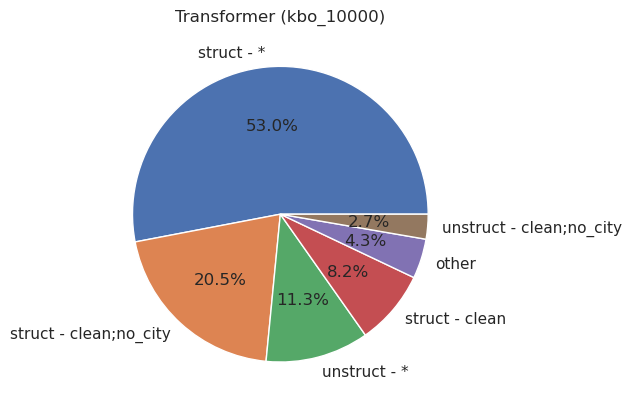

In [202]:
if "be_pelias" in geocoded_data.geocoder.unique():
    vc = geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: rec.raw["bepelias"]["call_type"]+" - "+(rec.raw["bepelias"]["transformers"] or "*")).value_counts()
    display(vc)
    
    _vc = vc.reset_index()
    _vc.location = _vc.location.where(_vc["count"]>200, "other")
    _vc.groupby("location")["count"].sum().sort_values(ascending=False).rename("").plot.pie(autopct='%1.1f%%', 
                                                                                 title=f"Transformer ({dataset})")

#     vc.plot.pie()

In [203]:
# _vc.groupby("location")["count"].sum().sort_values(ascending=False)
geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: "interpolated" in rec.raw["bepelias"]).value_counts()

location
False    9939
True       60
Name: count, dtype: int64

In [204]:
geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

location
exact           9429
interpolated     308
fallback         262
Name: count, dtype: int64

In [205]:
pd.crosstab(geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]),
            geocoded_data[geocoded_data.geocoder=="be_pelias"].location.apply(lambda rec: "interpolated" in rec.raw["bepelias"])
           )

location,False,True
location,,
exact,9369,60
fallback,262,0
interpolated,308,0


In [206]:
bp = geocoded_data[geocoded_data.geocoder=="be_pelias"]
bp[bp.location.apply(lambda loc: loc.raw["properties"]["match_type"] == "interpolated")]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision
47,47,Kattenstraat,33,8800,Roeselare,"Kattenstraat, 33, 8800 Roeselare, Belgique","(33 Kattenstraat, 8800 Roeselare, (50.9468827,...",be_pelias,0.025709,building
48,48,Kaardeloodstraat,6,9400,Ninove,"Kaardeloodstraat, 6, 9400 Ninove, Belgique","(6 Kaardeloodstraat, 9400 Ninove, (50.8364399,...",be_pelias,0.021872,building
56,56,Dendermondesteenweg,270,9070,Destelbergen,"Dendermondesteenweg, 270, 9070 Destelbergen, B...","(270 Dendermondesteenweg, 9070 Destelbergen, (...",be_pelias,0.024111,building
85,85,Rue de la Fonderie,16-18,4030,Liège,"Rue de la Fonderie, 16-18, 4030 Liège, Belgique","(17 Rue de la Fonderie, 4030 Liège, (50.620194...",be_pelias,0.022552,building
90,90,Statiestraat,19-21,2600,Antwerpen,"Statiestraat, 19-21, 2600 Antwerpen, Belgique","(20 Statiestraat, 2600 Antwerpen, (51.1974017,...",be_pelias,0.034844,building
...,...,...,...,...,...,...,...,...,...,...
9879,9879,Rue Zénobe Gramme,26,4280,Hannut,"Rue Zénobe Gramme, 26, 4280 Hannut, Belgique","(26 Rue Zénobe Gramme, 4280 Hannut, (50.671603...",be_pelias,0.015500,building
9883,9883,Knesselarestraat,213,8730,Beernem,"Knesselarestraat, 213, 8730 Beernem, Belgique","(213 Knesselarestraat, 8730 Beernem, (51.14611...",be_pelias,0.016033,building
9888,9888,Vondelpark,140,3120,Tremelo,"Vondelpark, 140, 3120 Tremelo, Belgique","(140 Vondelpark, 3120 Tremelo, (51.0121986, 4....",be_pelias,0.056814,building
9908,9908,Deerlijkstraat(Z),120,8550,Zwevegem,"Deerlijkstraat(Z), 120, 8550 Zwevegem, Belgique","(120 Deerlijkstraat, 8550 Zwevegem, (50.817435...",be_pelias,0.039344,building


In [207]:
bp.loc[47].location.raw

{'type': 'Feature',
 'geometry': {'type': 'Point', 'coordinates': [3.119657, 50.9468827]},
 'properties': {'id': 'bevlg_nl_street_58052',
  'gid': 'openstreetmap:address:bevlg_nl_street_58052',
  'layer': 'address',
  'source': 'openstreetmap',
  'source_id': 'bevlg_nl_street_58052',
  'country_code': 'BE',
  'name': '33 Kattenstraat, 8800 Roeselare',
  'housenumber': '33',
  'street': 'Kattenstraat',
  'postalcode': '8800',
  'confidence': 0.8,
  'match_type': 'interpolated',
  'accuracy': 'point',
  'country': 'Belgium',
  'country_gid': 'whosonfirst:country:85632997',
  'country_a': 'BEL',
  'macroregion': 'Flemish Region',
  'macroregion_gid': 'whosonfirst:macroregion:404227357',
  'region': 'West-Vlaanderen',
  'region_gid': 'whosonfirst:region:85681709',
  'region_a': 'WV',
  'county': 'Roeselare',
  'county_gid': 'whosonfirst:county:102049977',
  'county_a': 'RS',
  'localadmin': 'Roeselare',
  'localadmin_gid': 'whosonfirst:localadmin:1108830397',
  'locality': 'Roeselare',
  '

In [208]:
bp[bp.location.apply(lambda loc: "interpolated" in loc.raw["bepelias"])]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision
51,51,Route d' Aubel,69,4890,Thimister-Clermont,"Route d' Aubel, 69, 4890 Thimister-Clermont, B...","(69A, Route d'Aubel, 4890 Thimister-Clermont, ...",be_pelias,0.109864,building
84,84,Rue Vovegnez,69,4860,Pepinster,"Rue Vovegnez, 69, 4860 Pepinster, Belgique","(69, Rue Vovegnez, 4860 Pepinster, (50.5714496...",be_pelias,0.081506,building
145,145,Rue de Pernelle,9,5660,Couvin,"Rue de Pernelle, 9, 5660 Couvin, Belgique","(9, Rue de Pernelle, 5660 Couvin, (50.0341079,...",be_pelias,0.092876,building
375,375,Rue Grande(SG),75,7330,Saint-Ghislain,"Rue Grande(SG), 75, 7330 Saint-Ghislain, Belgique","(75, Rue Grande, 7330 Saint-Ghislain, (50.4448...",be_pelias,0.114789,building
655,655,Rue du Samson,25,5300,Andenne,"Rue du Samson, 25, 5300 Andenne, Belgique","(25A, Rue du Samson, 5300 Andenne, (50.4647098...",be_pelias,0.100042,building
680,680,Rue René Vanquelefs(EP),106,7134,Binche,"Rue René Vanquelefs(EP), 106, 7134 Binche, Bel...","(106A, Rue René Vanquelefs, 7134 Binche, (50.4...",be_pelias,0.075903,building
801,801,Rue d'Abhooz,6,4040,Herstal,"Rue d'Abhooz, 6, 4040 Herstal, Belgique","(6, Rue d'Abhooz, 4040 Herstal, (50.6913099, 5...",be_pelias,0.099605,building
1099,1099,Cour des Haies,45,6200,Châtelet,"Cour des Haies, 45, 6200 Châtelet, Belgique","(45, Cour des Haies, 6200 Châtelet, (50.418081...",be_pelias,0.075224,building
1516,1516,Rue Amedée de Lantremange (Blt),2/A,4300,Waremme,"Rue Amedée de Lantremange (Blt), 2/A, 4300 War...","(2B, Rue Amedée de Lantremange, 4300 Waremme, ...",be_pelias,0.971685,building
1751,1751,"Weywertz,Trippengasse",6,4750,Bütgenbach,"Weywertz,Trippengasse, 6, 4750 Bütgenbach, Bel...","(6, Trippengasse, 4750 Bütgenbach, (50.4330002...",be_pelias,0.151910,building


In [209]:
bp.loc[9955].location.raw

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [4.1614736, 50.4852824],
  'coordinates_orig': [0, 0]},
 'properties': {'id': 'bewal_fr_1868090',
  'gid': 'be-wal:address:bewal_fr_1868090',
  'layer': 'address',
  'source': 'be-wal',
  'source_id': 'bewal_fr_1868090',
  'name': '4, Rue de la Chaudronnerie, 6230 Pont-à-Celles',
  'housenumber': '4',
  'street': 'Rue de la Chaudronnerie',
  'postalcode': '6230',
  'confidence': 1,
  'match_type': 'exact',
  'accuracy': 'point',
  'label': '4, Rue de la Chaudronnerie, 6230 Pont-à-Celles',
  'addendum': {'best': {'best_id': 1868090,
    'name_fr': '4, Rue de la Chaudronnerie, 6230 Pont-à-Celles',
    'streetname_fr': 'Rue de la Chaudronnerie',
    'municipality_name_fr': 'Pont-à-Celles',
    'postname_fr': 'Pont-à-Celles',
    'NIS': 52055,
    'street_id': 7711083,
    'status': 'current',
    'box_info': [{'lat': 49.29391,
      'lon': 2.3055,
      'box_number': '0003',
      'address_id': 1868093,
      'status': 'c

# Distance to median statistics

## Extract location

In [210]:
lat = geocoded_data["location"].apply(lambda loc: loc.point.latitude if loc and loc.point.latitude >0 else None)
lng =  geocoded_data["location"].apply(lambda loc: loc.point.longitude if loc else None)
geocoded_data["point"] = np.where(lat.notnull(), gpd.points_from_xy(lng, lat), pd.NA)

In [211]:
geocoded_data[geocoded_data.point.isnull()]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point
104,104,Spaans-Huisdreef,1,3080,Tervuren,"Spaans-Huisdreef, 1, 3080 Tervuren, Belgique","(Spaans-Huisdreef, 3080 Tervuren, (0.0, 0.0))",be_pelias,0.216589,country,<NA>
165,165,"Rue Jules Poskin,Isnes",3,5032,Gembloux,"Rue Jules Poskin,Isnes, 3, 5032 Gembloux, Belg...","(Rue Jules Poskin, 5030 Gembloux, (0.0, 0.0))",be_pelias,0.307499,country,<NA>
546,546,Rue des Ecomines,39,4900,Spa,"Rue des Ecomines, 39, 4900 Spa, Belgique","(39, Rue des Ecomines, 4900 Spa, (0.0, 0.0))",be_pelias,0.078162,country,<NA>
597,597,Rue Troisfontaines,92,4670,Blégny,"Rue Troisfontaines, 92, 4670 Blégny, Belgique","(92, Rue Troisfontaines, 4670 Blegny, (0.0, 0.0))",be_pelias,0.086247,country,<NA>
668,668,"Rue Fosses-aux-Chênes,Aisemont",144B,5070,Fosses-la-Ville,"Rue Fosses-aux-Chênes,Aisemont, 144B, 5070 Fos...","(29, Rue Fosses-aux-Chênes, 5070 Fosses-la-Vil...",be_pelias,0.144543,country,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
9291,9291,Chaussée de Huy,205,1325,Chaumont-Gistoux,"Chaussée de Huy, 205, 1325 Chaumont-Gistoux, B...","(205, Chaussée de Huy, 1325 Chaumont-Gistoux, ...",be_pelias,0.075246,country,<NA>
9640,9640,Sentier de la Longue-Haie,11,1400,Nivelles,"Sentier de la Longue-Haie, 11, 1400 Nivelles, ...","(Sentier de la Longue Haie, 1400 Nivelles, (0....",be_pelias,0.206938,country,<NA>
9689,9689,Rue Joncquerelle(G-R),80,7530,Tournai,"Rue Joncquerelle(G-R), 80, 7530 Tournai, Belgique","(80, Rue Joncquerelle, 7530 Tournai, (0.0, 0.0))",be_pelias,0.072482,country,<NA>
9742,9742,Val de la Berwinne,13,4890,Thimister-Clermont,"Val de la Berwinne, 13, 4890 Thimister-Clermon...","(13, Val de la Berwinne, 4890 Thimister-Clermo...",be_pelias,0.088560,country,<NA>


<Axes: >

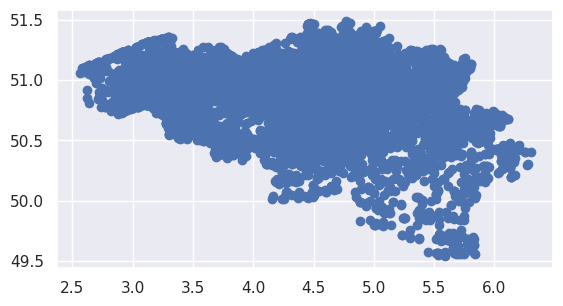

In [212]:
geocoded_data[geocoded_data.point.notnull()].set_geometry("point").plot()

In [213]:
geocoded_data = geocoded_data[geocoded_data.point.notnull()] 

In [214]:
geocoded_data = gpd.GeoDataFrame(geocoded_data).set_geometry("point").set_crs(osm_crs, allow_override=True).to_crs(crs)
geocoded_data

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point
0,0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be...","(200, Dendermondsesteenweg, 2830 Willebroek, (...",be_pelias,0.067911,building,POINT (483875.770 6631823.569)
1,1,Boulevard du Régent,47,1000,Bruxelles,"Boulevard du Régent, 47, 1000 Bruxelles, Belgique","(47, Boulevard du Régent, 1000 Bruxelles, (50....",be_pelias,0.090556,building,POINT (486332.591 6594343.048)
2,2,Hauwaart,44,9700,Oudenaarde,"Hauwaart, 44, 9700 Oudenaarde, Belgique","(44, Hauwaart, 9700 Oudenaarde, (50.83173, 3.6...",be_pelias,0.036578,building,POINT (407795.577 6591582.510)
3,3,Bruynebosstraat,40,3511,Hasselt,"Bruynebosstraat, 40, 3511 Hasselt, Belgique","(40, Bruynebosstraat, 3511 Hasselt, (50.97784,...",be_pelias,0.034922,building,POINT (586172.816 6617374.811)
4,4,Steenwinkelstraat,583,2627,Schelle,"Steenwinkelstraat, 583, 2627 Schelle, Belgique","(583, Steenwinkelstraat, 2627 Schelle, (51.122...",be_pelias,0.104132,building,POINT (486022.010 6643028.472)
...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,Willy Staeslei,51,2180,Antwerpen,"Willy Staeslei, 51, 2180 Antwerpen, Belgique","(51, Willy Staeslei, 2180 Antwerpen, (51.28986...",be_pelias,0.016587,building,POINT (494324.218 6672727.651)
9996,9996,Oesterbankstraat,15,8400,Oostende,"Oesterbankstraat, 15, 8400 Oostende, Belgique","(15, Oesterbankstraat, 8400 Oostende, (51.2263...",be_pelias,0.014645,building,POINT (325556.077 6661430.506)
9997,9997,Peene,10,9185,Wachtebeke,"Peene, 10, 9185 Wachtebeke, Belgique","(10A, Peene, 9185 Wachtebeke, (51.17131, 3.886...",be_pelias,0.015121,building,POINT (432657.673 6651652.604)
9998,9998,Breekpot(Onk),28,9500,Geraardsbergen,"Breekpot(Onk), 28, 9500 Geraardsbergen, Belgique","(28, Breekpot, 9500 Geraardsbergen, (50.78497,...",be_pelias,0.035424,building,POINT (435366.076 6583345.186)


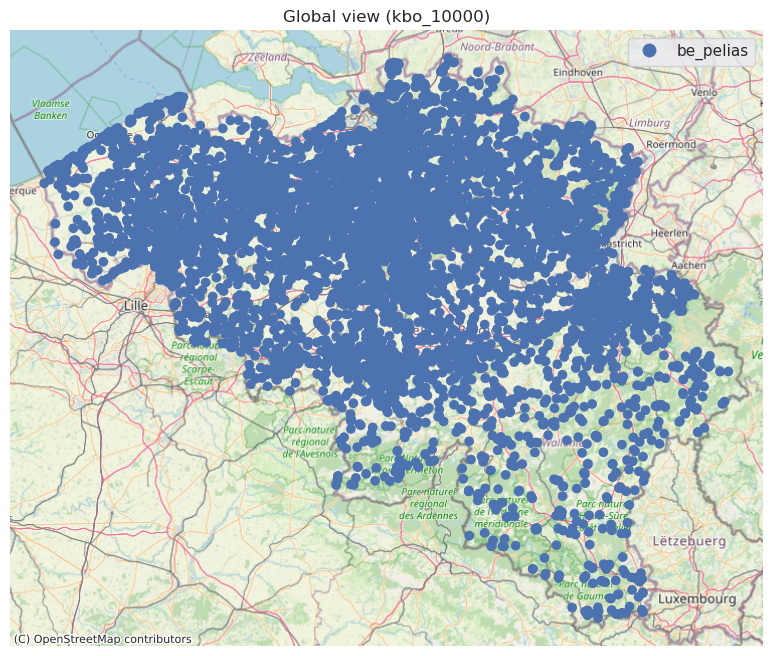

In [215]:
from matplotlib.colors import ListedColormap

colors = ListedColormap([f"C{i}" for i in range(geocoded_data.geocoder.nunique())], name="mycmap")
ax=geocoded_data.plot("geocoder", legend=True, figsize=def_figsize, cmap=colors)
plt.title(f"Global view ({dataset})")
add_basemap(ax)
# img_name=f"{fig_path}/global_{dataset}.png"
# plt.savefig(img_name,  bbox_inches='tight')
# pdf_add_image(pdf, img_name)
# pdf.add_page()
# pdf.image(f"{fig_path}/global_{dataset}.png", 0, 0, 290)
plt.axis("off")
pdf_savefig()
# plt.show()
# plt.close()

In [216]:
belgium_boundaries = gpd.read_file("data/boundaries.geojson", driver="GeoJSON")
belgium_boundaries = belgium_boundaries[belgium_boundaries.name == "BEL"].geometry.iloc[0].simplify(1000).buffer(1000)
# belgium_boundaries

In [217]:
import fiona

In [218]:
geocoded_data["is_in_belgium"]= geocoded_data.geometry.within(belgium_boundaries)
geocoded_data["is_in_belgium"].value_counts()

is_in_belgium
True     9922
False       1
Name: count, dtype: int64

In [219]:
geocoded_data[~geocoded_data.is_in_belgium]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium
4269,4269,Molenstraat,66,2387,Baarle-Hertog,"Molenstraat, 66, 2387 Baarle-Hertog, Belgique","(66, Molenstraat, 2387 Baarle-Hertog, (51.4390...",be_pelias,0.019271,building,POINT (549092.294 6699321.787),False


In [220]:
geocoded_data.groupby("geocoder").is_in_belgium.value_counts()

geocoder   is_in_belgium
be_pelias  True             9922
           False               1
Name: count, dtype: int64

In [221]:
geocoded_data[~geocoded_data.is_in_belgium]

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium
4269,4269,Molenstraat,66,2387,Baarle-Hertog,"Molenstraat, 66, 2387 Baarle-Hertog, Belgique","(66, Molenstraat, 2387 Baarle-Hertog, (51.4390...",be_pelias,0.019271,building,POINT (549092.294 6699321.787),False


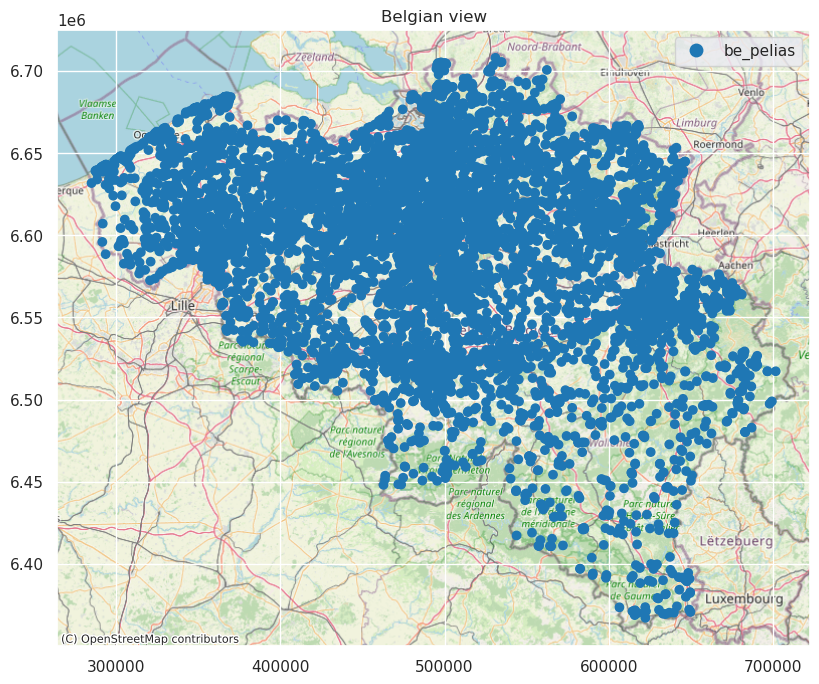

In [222]:
ax=geocoded_data[geocoded_data.is_in_belgium].plot("geocoder", legend=True, figsize=def_figsize)
plt.title("Belgian view")
add_basemap(ax)
pdf_savefig()

## Compute (distance to) median

In [223]:
def get_median_point(bloc):
    bloc = gpd.GeoSeries(bloc.dropna())
    x = np.median(bloc.x)
    y = np.median(bloc.y)
    return shapely.geometry.Point(x, y), bloc.shape[0]
 

In [224]:
# geocoded_data.address.drop_duplicates()

In [225]:
median_geocoders = coders # ["here", "bing", "mapbox", "tomtom", "nominatim_wrapper", "google", "bestaddress"] # Median based on those geocoders
median_points = geocoded_data[geocoded_data.geocoder.isin(median_geocoders)&( geocoded_data.precision=="building") ].groupby("address").point.apply(get_median_point).apply(pd.Series)#.rename("median_point").reset_index()
median_points = median_points.rename(columns={0: "median_point", 1: "nb_points"}).reset_index()
median_points = median_points.set_geometry("median_point").set_crs(geocoded_data.crs)
median_points

,address,median_point,nb_points
0,"""Le Rosai"", 5, 4052 Chaudfontaine, Belgique",POINT (626914.637 6542984.218),1
1,"'s Boschstraat, 30, 2320 Hoogstraten, Belgique",POINT (530633.296 6693148.708),1
2,"'s Gravenwezelsteenweg, 59, 2110 Wijnegem, Bel...",POINT (504788.072 6662903.479),1
3,"'s Heerwillems, 14, 8630 Veurne, Belgique",POINT (305100.008 6634854.577),1
4,"'s Herenbaan, 211, 2850 Boom, Belgique",POINT (486443.911 6639971.392),1
...,...,...,...
9503,"rue du Barrage,Robertville, 46, 4950 Waimes, B...",POINT (680587.329 6525451.654),1
9504,"rue du Chapy,Ws, 52, 5570 Beauraing, Belgique",POINT (552306.088 6462239.508),1
9505,"rue du Luxembourg, 70, 5570 Beauraing, Belgique",POINT (553236.719 6464743.706),1
9506,"van Willigenstraat, 32, 3560 Lummen, Belgique",POINT (576978.940 6618179.309),1


<Axes: ylabel='count'>

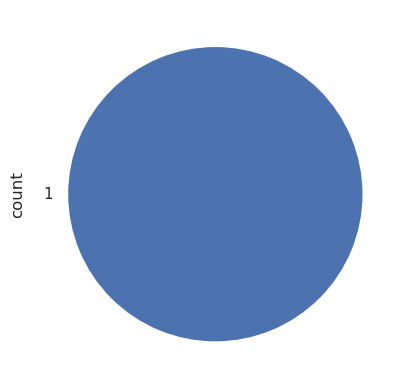

In [226]:
median_points.nb_points.value_counts().plot.pie()

In [227]:
median_points = median_points[median_points.nb_points >= min(3,median_points.nb_points.max()) ]
median_points.shape

(9508, 3)

In [228]:
geocoded_data = geocoded_data.merge(median_points, how="left")#.dropna()
# geocoded_data

In [229]:
geocoded_data["dist_to_median"] = geocoded_data.point.distance(geocoded_data.median_point.set_crs(geocoded_data.crs))
geocoded_data.sort_values("dist_to_median")#.tail(100)

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium,median_point,nb_points,dist_to_median
0,0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be...","(200, Dendermondsesteenweg, 2830 Willebroek, (...",be_pelias,0.067911,building,POINT (483875.770 6631823.569),True,POINT (483875.770 6631823.569),1.0,0.0
6612,6668,Stuivenbergbaan,28-30,2800,Mechelen,"Stuivenbergbaan, 28-30, 2800 Mechelen, Belgique","(28, Stuivenbergbaan, 2800 Mechelen, (51.02636...",be_pelias,0.122715,building,POINT (496546.155 6625957.827),True,POINT (496546.155 6625957.827),1.0,0.0
6613,6669,Rue du Grand Sart,7,1390,Grez-Doiceau,"Rue du Grand Sart, 7, 1390 Grez-Doiceau, Belgique","(7, Rue de la Ferme du Grand Sart, 1390 Grez-D...",be_pelias,0.016227,building,POINT (525190.886 6571229.672),True,POINT (525190.886 6571229.672),1.0,0.0
6614,6670,"Rue Florichamps,Laloux",6,5580,Rochefort,"Rue Florichamps,Laloux, 6, 5580 Rochefort, Bel...","(6, Rue Florichamps, 5580 Rochefort, (50.18191...",be_pelias,0.070172,building,POINT (574251.612 6477839.253),True,POINT (574251.612 6477839.253),1.0,0.0
6615,6671,Antwerpsestraat,148,2640,Mortsel,"Antwerpsestraat, 148, 2640 Mortsel, Belgique","(148, Antwerpsestraat, 2640 Mortsel, (51.17408...",be_pelias,0.066049,building,POINT (494623.667 6652144.418),True,POINT (494623.667 6652144.418),1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9822,9899,"Rue de Perwez, Gd-L.",68,5031,Gembloux,"Rue de Perwez, Gd-L., 68, 5031 Gembloux, Belgique","(Rue de Perwez, 5031 Gembloux, (50.590845, 4.7...",be_pelias,1.253558,street,POINT (531873.506 6549235.588),True,None,NaN,NaN
9877,9954,Zonnestraat,-,3560,Lummen,"Zonnestraat, -, 3560 Lummen, Belgique","(Zonnestraat, 3560 Lummen, (50.988801, 5.195743))",be_pelias,0.371988,street,POINT (578387.465 6619312.988),True,None,NaN,NaN
9879,9956,Mechelsebaan,ZN,2570,Duffel,"Mechelsebaan, ZN, 2570 Duffel, Belgique","(Mechelsebaan, 2570 Duffel, (51.082114, 4.4991...",be_pelias,0.238043,street,POINT (500847.985 6635831.612),True,None,NaN,NaN
9896,9973,"Rue Léon-Colleaux,St-Mard",SN,6762,Virton,"Rue Léon-Colleaux,St-Mard, SN, 6762 Virton, Be...","(Rue Léon Colleaux, 6762 Virton, (49.555019, 5...",be_pelias,0.366481,street,POINT (615777.233 6369566.651),True,None,NaN,NaN


In [230]:
# geocoded_data[geocoded_data.median_point.isnull()].sort_values("address")

In [231]:
# geocoded_data.sort_values("dist_to_median").tail(40).geocoder.value_counts().plot.bar()

In [232]:
def plot_address(geocoded_data, a):
    df = geocoded_data[(geocoded_data.address==a)]
    display(df)
    

    ax = df.assign(label=df.geocoder + " ("+df.dist_to_median.fillna(-1).astype(int).astype(str) + " - " + df.precision + ")").plot(
        "label", 
        legend=True, 
        markersize=100,
            figsize=def_figsize
    )

    if df.dist_to_median.isnull().all():
        print("No median point")
    else: 
        med=df[["median_point"]].drop_duplicates().set_geometry("median_point")
                                                                                                                         
        med.plot(ax=ax, color="red", marker="x", markersize=100)
    ax.set_title(a)
    set_optimal_limits(ax, df)
    add_basemap(ax)
    plt.show()    
    return ax

In [233]:
# plot_address(geocoded_data, geocoded_data.loc[46].address)

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium,median_point,nb_points,dist_to_median
0,0,Dendermondsesteenweg,200,2830,Willebroek,"Dendermondsesteenweg, 200, 2830 Willebroek, Be...","(200, Dendermondsesteenweg, 2830 Willebroek, (...",be_pelias,0.067911,building,POINT (483875.770 6631823.569),True,POINT (483875.770 6631823.569),1.0,0.0


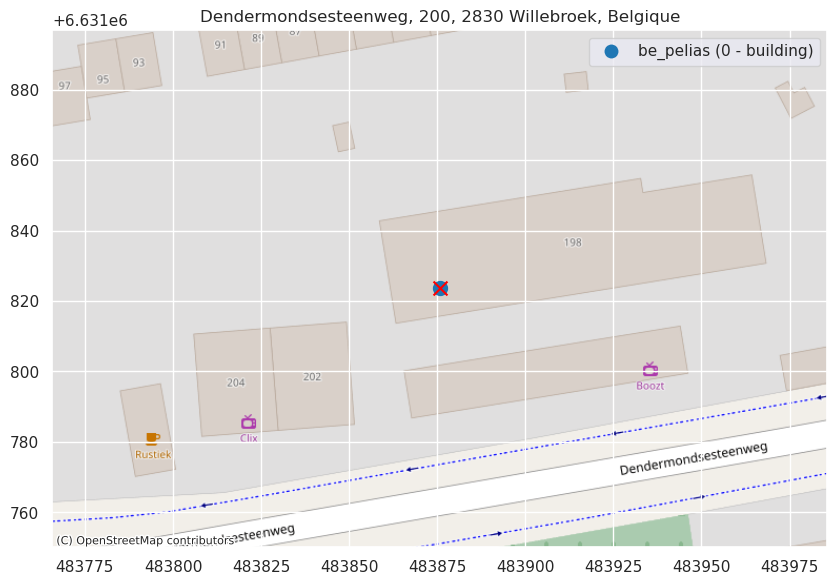

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium,median_point,nb_points,dist_to_median
6610,6666,Koekoekenstraat,9,3078,Kortenberg,"Koekoekenstraat, 9, 3078 Kortenberg, Belgique","(9, Koekoekenstraat, 3078 Kortenberg, (50.8731...",be_pelias,0.01442,building,POINT (504910.701 6598882.497),True,POINT (504910.701 6598882.497),1.0,0.0


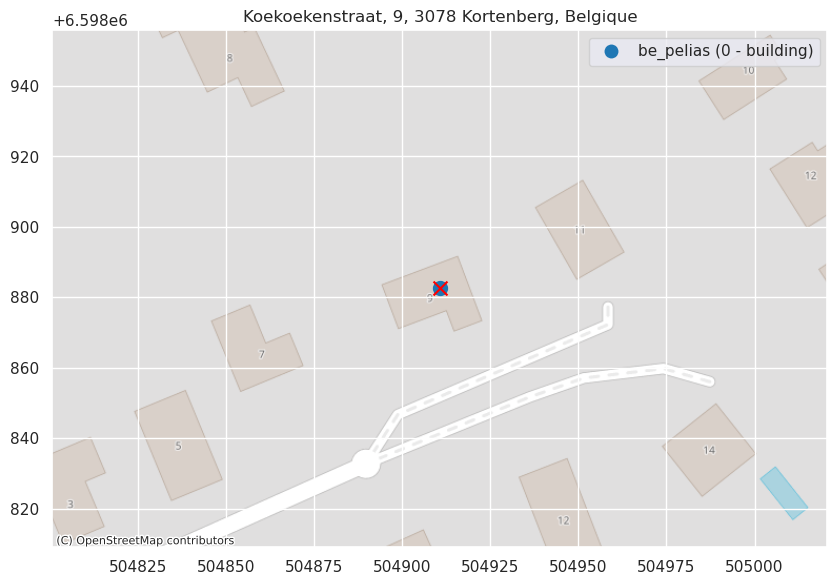

,reference_key,street,housenumber,postcode,city,address,location,geocoder,duration,precision,point,is_in_belgium,median_point,nb_points,dist_to_median
6612,6668,Stuivenbergbaan,28-30,2800,Mechelen,"Stuivenbergbaan, 28-30, 2800 Mechelen, Belgique","(28, Stuivenbergbaan, 2800 Mechelen, (51.02636...",be_pelias,0.122715,building,POINT (496546.155 6625957.827),True,POINT (496546.155 6625957.827),1.0,0.0


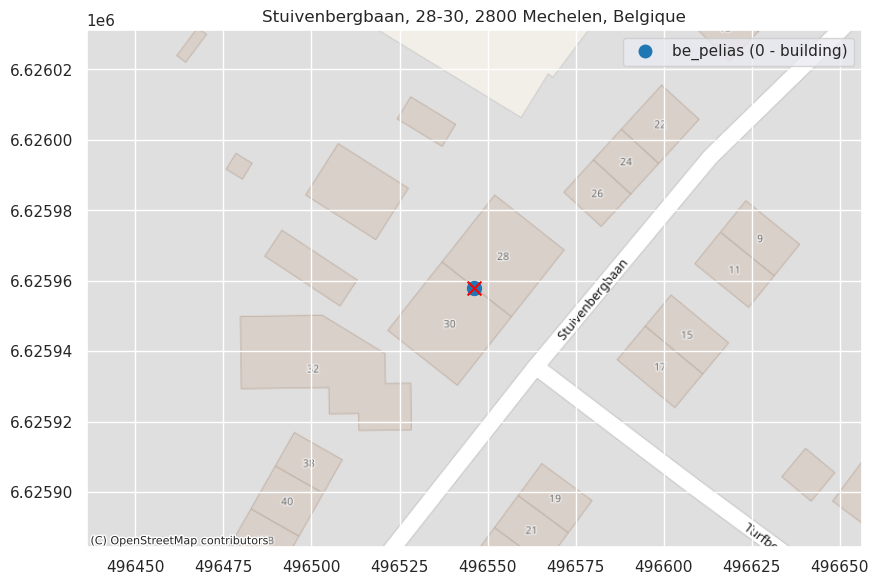

In [234]:
for a in geocoded_data.sort_values("dist_to_median", ascending=False).address.unique()[0:3]:
    #print(a)
    plot_address(geocoded_data, a)
   

## Median pertinence

How many close to median ?

In [235]:
nb_close_to_median = geocoded_data.assign(close_to_median = geocoded_data.dist_to_median < 100).groupby("address").close_to_median.sum()
nb_close_to_median

address
"Le Rosai", 5, 4052 Chaudfontaine, Belgique            1
's Boschstraat, 30, 2320 Hoogstraten, Belgique         1
's Gravendreef, 197, 9810 Nazareth, Belgique           0
's Gravenwezelsteenweg, 59, 2110 Wijnegem, Belgique    1
's Heerwillems, 14, 8630 Veurne, Belgique              1
                                                      ..
rue du Chapy,Ws, 52, 5570 Beauraing, Belgique          1
rue du Luxembourg, 70, 5570 Beauraing, Belgique        1
van Groesbeekstraat, ZN, 3511 Hasselt, Belgique        0
van Willigenstraat, 32, 3560 Lummen, Belgique          1
à la Corne du Pré, 9, 4053 Chaudfontaine, Belgique     1
Name: close_to_median, Length: 9923, dtype: int64

In [236]:
median_points = median_points.merge(nb_close_to_median.rename("nb_close_to_median").reset_index())

In [237]:
median_points.nb_close_to_median.value_counts()

nb_close_to_median
1    9508
Name: count, dtype: int64

In [238]:
median_points[median_points.nb_close_to_median>=2]

,address,median_point,nb_points,nb_close_to_median


In [239]:
# nb_close_to_median.value_counts()

In [240]:
geocoded_data = geocoded_data.merge(median_points, how="left")

In [241]:
geocoded_data.loc[geocoded_data.nb_close_to_median <2, "dist_to_median"] = pd.NA

In [242]:
geocoded_data[geocoded_data.dist_to_median.notnull()].address.nunique()

0

In [243]:
for a in nb_close_to_median[nb_close_to_median==0].iloc[0:4].index:
    if geocoded_data[geocoded_data.address == a].median_point.notnull().any():
        plot_address(geocoded_data[geocoded_data.median_point.notnull()], a)

In [244]:
geocoded_data.to_pickle(f"output/geocoding/geocoded_data/geocoded_{dataset}_all.pkl")

## Distance to median

### Average

geocoder
be_pelias   NaN
Name: dist_to_median, dtype: float64

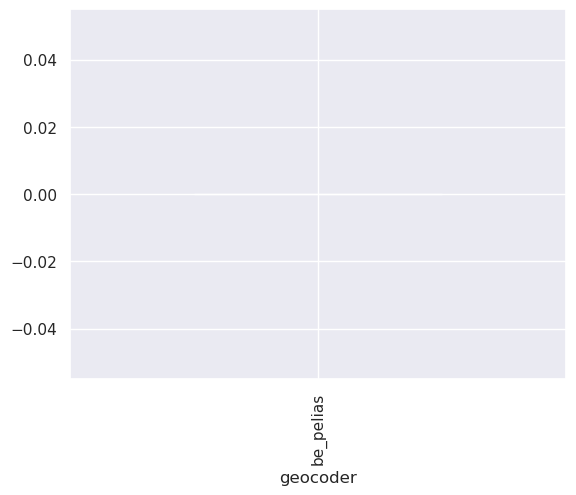

In [245]:
# d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data.groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_{dataset}.png")
d2m

geocoder
be_pelias   NaN
Name: dist_to_median, dtype: float64

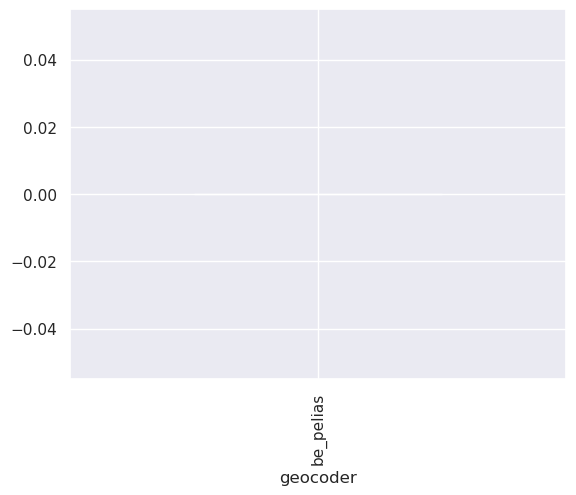

In [246]:
# skipping non reliable median

# d2m = geocoded_data[geocoded_data.is_reliable].groupby("geocoder").dist_to_median.mean()
d2m = geocoded_data[geocoded_data.is_in_belgium].groupby("geocoder").dist_to_median.mean()
d2m.plot.bar()
# plt.savefig(f"{fig_path}/dist2med_reliable_{dataset}.png")
d2m

### Percentiles

In [247]:
#[geocoded_data.precision=="building"]#.drop_duplicates(subset="address")
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import LogLocator
def dist_to_median_line_plot(d, ax=None, title=None, legend=True):
    mean = d.groupby("geocoder").dist_to_median.mean().rename("Mean")

    perc_90 = d.groupby("geocoder").dist_to_median.quantile(0.90).rename("Perc 90%")
    perc_95 = d.groupby("geocoder").dist_to_median.quantile(0.95).rename("Perc 95%")
    perc_99 = d.groupby("geocoder").dist_to_median.quantile(0.99).rename("Perc 99%")
    perc_50 = d.groupby("geocoder").dist_to_median.quantile(0.50).rename("Median")
    maxd = d.groupby("geocoder").dist_to_median.max().rename("Max")
    tops = [ d.groupby("geocoder").dist_to_median.nlargest(i).reset_index().groupby("geocoder").dist_to_median.min() for i in range(2, 50)]#.drop_index(level=1)#@@.tail(1)#.unstack()
#     mean    = mean.sort_values()
#     perc_90 = perc_90.reindex_like(mean)
#     perc_99 = perc_99.reindex_like(mean)
#     perc_50 = perc_50.reindex_like(mean)
#     maxd =    maxd.reindex_like(mean)

    mean    = mean.reindex(coders)
#     perc_90 = perc_90.reindex(coders)
    perc_95 = perc_95.reindex(coders)
    perc_50 = perc_50.reindex(coders)
    maxd =    maxd.reindex(coders)
    tops =    [t.reindex(coders) for t in tops]

    display(mean)
    ax = mean.plot(legend=legend, linestyle='dotted',marker='s', ax=ax, title=title, figsize=def_figsize)
    ax = perc_50.plot(ax=ax, legend=legend,linestyle='dotted', marker='<')
    # ax = perc_90.rename("Perc 90%").plot(ax=ax, legend=True, linestyle='dotted', marker='o')
    ax = perc_95.plot(ax=ax, legend=legend, linestyle='dotted', marker='P')
    # ax = perc_99.rename("Perc 99%").plot(ax=ax, legend=True, linestyle='dotted', marker='P')
    ax = maxd.plot(ax=ax, rot=90, legend=legend, linestyle='dotted',marker='^', logy=True)
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    for t in tops:
        t.plot(ax=ax, rot=90, legend=False, linestyle="", marker='.', logy=True, c='C3', zorder=1, alpha=0.2)
    ax.set_ylabel(f"Distance to median point ({dataset})")
#     ax.set_yscale("log")
#     ax.spines['left'].set_color('red')
#     plt.tick_params(axis='y', which='minor')
#     ax.tick_params(axis='y', colors='red')
#     ax.minorticks_on()
    ax.tick_params(axis="both", direction="out", which="both", left=True, top=False)
#     ax.yaxis.set_minor_locator(LogLocator(5))
#     ax.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax.set_xlabel(None)
    display(pd.DataFrame([mean, perc_50, perc_95, maxd]))
    


In [248]:
dist_to_median_line_plot(geocoded_data)

pdf_savefig()


geocoder
be_pelias   NaN
Name: Mean, dtype: float64

geocoder,be_pelias
Mean,NaN
Median,NaN
Perc 95%,NaN
Max,NaN


ValueError: Data has no positive values, and therefore cannot be log-scaled.

Error in callback <function _draw_all_if_interactive at 0x7fabb6245f80> (for post_execute):


ValueError: Data has no positive values, and therefore cannot be log-scaled.

ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 1000x800 with 1 Axes>

In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.is_in_belgium]

dist_to_median_line_plot(d, ax[1], "Excluding outside Belgium", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street'])]

dist_to_median_line_plot(d, ax[1], "Only 'building', 'street'")

pdf_savefig()


In [ ]:
f, ax=plt.subplots(1,2, figsize=(12,5), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.precision.isin(["building", 'street']) & geocoded_data.apply(lambda rec: str(rec.postcode) in  str(rec.location.raw), axis=1)]

dist_to_median_line_plot(d, ax[1], "Excluding zipcode mismatches, \nonly 'building' and 'street'", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

In [ ]:
f, ax=plt.subplots(1,2, figsize=(16,8), sharey=True)
dist_to_median_line_plot(geocoded_data, ax[0], "All results")

# Keep only results containing input postcode (not fully accurate...)
d = geocoded_data[geocoded_data.reference_key.isin(geocoded_data[geocoded_data.geocoder=="jcd"].reference_key)]

dist_to_median_line_plot(d, ax[1], "Only addresses geocoded by jcd", legend=False)

d.groupby("geocoder").reference_key.count()/ geocoded_data.groupby("geocoder").reference_key.count()

# Geocoder outsiders

In [ ]:
gcd="jcd"

In [ ]:
x = geocoded_data[geocoded_data.geocoder==gcd].sort_values("dist_to_median")
x

In [ ]:
for addr in x.iloc[-10:].address:
    
    plot_address(geocoded_data, addr)

In [ ]:

# plot_address(geocoded_data, geocoded_data.loc[7930].address)

In [ ]:
pdf.close()

# Tests

In [ ]:
geocoded_data[geocoded_data.geocoder=="ngi_pelias"].precision.value_counts()

In [ ]:
# geocoded_data[(geocoded_data.geocoder=="ngi_pelias") & (geocoded_data.precision != "building")].sort_values(["precision", "postcode"]).iloc[0:60]

In [ ]:
geocoders["pelias"].geocode({'address': f'A VIBON DJU(DU VIEUX BON DIEU',
   'postalcode': '4350',
   'locality': 'remicourt'}).raw
#     print res["properties"][""]

In [ ]:
geocoders["be_pelias"].geocode({'street': f'Rue Marconi',
                                 'housenumber':'113',
   'postcode': '1190',
   'city': 'forest'}).raw
#     print res["properties"][""]

In [ ]:
# geocoders["pelias"].geocode("Rue Auguste Heen, 17, 1190").raw

In [ ]:
# geocoded_data[geocoded_data.geocoder=="ngi_pelias"].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

In [ ]:
# geocoded_data[(geocoded_data.geocoder=="ngi_pelias") & (geocoded_data.precision=="street")].location.apply(lambda rec: rec.raw["properties"]["match_type"]).value_counts()

In [ ]:
pelias_res = geocoded_data[(geocoded_data.geocoder=="ngi_pelias")]

pelias_res[pelias_res.precision!="building"].sort_values(["precision", "postcode"])#.iloc[0:60]

In [ ]:
# pelias_res.loc[291].location.raw

In [ ]:
pelias_res[pelias_res.location.apply(lambda rec: rec.raw["properties"]["match_type"]== "fallback" and rec.raw["properties"]["accuracy"]== "point") ]

In [ ]:
pelias_res[pelias_res.location.apply(lambda rec: rec.raw["properties"]["accuracy"]== "point") & (pelias_res.precision!="building") ]

In [ ]:
pelias_res.loc[52].location.raw

In [ ]:
data#set

In [ ]:
k = 432

d =data.loc[k]
display(d)
d = d.str.replace("(L.L)", "", regex=False)
display(d)

r = geocoders["ngi_pelias"].geocode(d.to_dict(), exactly_one=False)#[0].raw

r

In [ ]:
r[0].raw

In [ ]:
data.loc[k]

In [ ]:
geocoded_data.location.iloc[1].raw["properties"]

In [ ]:
geocoded_data["pelias_street"] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["street"] if rec and "properties" in rec.raw and "street" in rec.raw["properties"] else pd.NA)
geocoded_data["pelias_postalcode"] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["postalcode"] if rec and "properties" in rec.raw and "postalcode" in rec.raw["properties"] else pd.NA)

for f in 'municipality_name_fr', 'municipality_name_nl', 'municipality_name_de',  'postname_fr', 'postname_nl',  'postname_fr':
    geocoded_data["pelias_"+f] = geocoded_data.location.apply(lambda rec: rec.raw["properties"]["addendum"]["best"][f] if rec and "addendum" in rec.raw["properties"] and "best" in rec.raw["properties"]["addendum"] and f in rec.raw["properties"]["addendum"]["best"] else pd.NA)
    

In [ ]:
geocoded_data.drop(["reference_key", "address", "location", "geocoder", "duration", "is_in_belgium", "median_point", "nb_points", "dist_to_median", "nb_close_to_median"], axis=1, errors="ignore").to_csv("output/pelias_rep.csv")

In [ ]:
# geocoded_data[geocoded_data.pelias_postname_fr.notnull()]
dataset